In [1]:
from __future__ import division
import itertools

import numpy as np
from scipy import linalg
from scipy.stats import multivariate_normal, normaltest
from sklearn import mixture
from sklearn.datasets import load_iris
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import time
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [50]:
class StopWatch:
    def __init__(self):
        self.time = 0
        self.start_time = 0
    
    def reset(self):
        self.time = 0
    
    def start(self):
        self.start_time = time.time()
        
    def stop(self):
        self.time += time.time() - self.start_time

class MyModel:
    def __init__(self, n_gauss=5, err=0.01, data_size=64):
        self.err = err
        self.n_gauss = n_gauss
        self.data = None
        self.data_size = data_size
        self.watches = {}
        
    def load_data(self, dataset='iris'):
        if dataset == 'iris':
            self.data = load_iris(return_X_y=True)[0]
        elif dataset == 'iris_complete':
            self.data = load_iris(return_X_y=True)
            aux = np.array([[i] for i in self.data[1]])
            self.data = np.append(self.data[0], aux, axis=1)
        elif dataset == 'tpc-h-5k':
            self.data = np.delete(np.genfromtxt('sampled_items.csv', delimiter='|'), 2, 1)
        elif dataset == 'tpc-h-full':
            self.data = np.delete(np.genfromtxt('sampled_items_full.csv', delimiter='|'), 2, 1)
        
        if self.data is not None:
            self.n = self.data.shape[0]
            self.m = self.data.shape[1]
    
    def test_normality(self, column):
        z, pval = normaltest(self.data[:, column])
        print z, pval
        if(pval < 0.055):
            print "Not normal distribution"
        else:
            print "Normaaaaal!"
        
    def train(self, show=False):
        if self.data is None:
            print 'No data!'
            return
        self.gmm = mixture.GaussianMixture(n_components=self.n_gauss, max_iter=500).fit(self.data)
        self.mu = self.gmm.means_
        self.sigma = self.gmm.covariances_
        self.pi = self.gmm.weights_
        self.load_sigma_dots()
        self.anti_j = [np.arange(self.m) != j for j in range(self.m)]
        if show:
            print self.gmm
        
    def get_err_vec(self, data, completeRangeJ):
        return np.abs((completeRangeJ - data)/ data)

    def find_min(self, data, completeRangeJ):
        errs = self.get_err_vec(data, completeRangeJ)
        min_err = min(errs)
        try:
            return min_err, np.where(errs == min_err)[0][0]
        except:
            return np.inf, -1
        
    def load_sigma_dots(self):
        sigma_inverses = np.array(  [
                            [linalg.pinv(np.delete(np.delete(self.sigma[k], j, 0), j, 1)) for j in range(self.m)] 
                            for k in range(self.n_gauss)
                        ])
        self.sigma_dots = np.array(  [
                            [np.dot(np.delete(self.sigma[k, j], j), sigma_inverses[k, j]) for j in range(self.m)] 
                            for k in range(self.n_gauss)
                        ])
        
    def reset_values(self):
        self.mvns = {}
        
        self.compact = np.zeros((self.n, self.m))
        self.totalErrs = np.zeros((self.n, self.m))

        self.t = np.zeros((self.n, self.n_gauss))
        self.mub = np.zeros((self.n, self.m, self.n_gauss))
        self.xb = np.zeros((self.n, self.m))

        self.minDifs = np.zeros((self.n, self.m))
        self.minDifIdxs = np.array([[-1 for j in range(self.m)] for i in range(self.n)])

        self.totalRems = 0
        
    def get_mub_helper(self):
        return np.array([
                    [self.mu[k, j] - \
                        np.dot(
                            self.sigma_dots[k, j], self.mu[k, self.anti_j[j]]
                        ) 
                    for j in range(self.m)]
                for k in range(self.n_gauss)])
        
    def get_mub(self, i):
        return np.array([
                    [self.mub_helper[k, j] + \
                        np.dot(
                            self.sigma_dots[k, j], self.data[i, self.anti_j[j]]
                        ) 
                    for j in range(self.m)]
                for k in range(self.n_gauss)])
    
    def get_t(self, i, rangeJ, tup_rangeJ):
        pdfs = [self.mvns[tup_rangeJ][k].pdf(self.data[i][rangeJ]) for k in range(self.n_gauss)]
        
        den = sum([self.pi[pos]*pdfs[pos] for pos in range(self.n_gauss)])
        return [self.pi[k]*pdfs[k] / den for k in range(self.n_gauss)]
    
    def run(self, prefix=''):
        self.reset_values()
        self.mub_helper = self.get_mub_helper()
        
        self.watches['total_watch'] = StopWatch()
        self.watches['pred_watch'] = StopWatch()
        self.watches['mub_watch'] = StopWatch()

        self.watches['total_watch'].start()
        for i in range(self.n):
            if i%(self.n//100) == 0 or i == self.n-1:
                print '\r',
                print '{} {} / {}'.format(prefix, i+1, self.n),

            nRem = 0

            #--------------------------------------------------------- 
            # First bottleneck
            self.watches['mub_watch'].start()
            mub = self.get_mub(i)
            self.watches['mub_watch'].stop()
            #--------------------------------------------------------- 

            while(True):
                
                rangeJ = np.array([j for j in range(self.m) if j not in self.minDifIdxs[i]])
                tup_rangeJ = tuple(rangeJ)
                
                #---------------------------------------------------------
                if tup_rangeJ not in self.mvns:
                    r_mu = [self.mu[k, rangeJ] for k in range(self.n_gauss)]
                    r_sigma = [np.take(self.sigma[k, rangeJ], rangeJ, axis=1) for k in range(self.n_gauss)]

                    self.mvns[tup_rangeJ] = [multivariate_normal(mean, cov) for mean, cov in zip(r_mu, r_sigma)]
                #---------------------------------------------------------

                #--------------------------------------------------------- 
                # Second bottleneck
                self.watches['pred_watch'].start()
                t = self.get_t(i, rangeJ, tup_rangeJ)
                self.watches['pred_watch'].stop()
                #---------------------------------------------------------
                self.xb[i] = [sum([t[k]*mub[k, j] for k in range(self.n_gauss)]) for j in range(self.m)]
                
                erros = self.get_err_vec(self.data[i], self.xb[i])
            
                completeRangeJ = self.xb[i]
                for j in range(self.m):
                    if j not in rangeJ:
                        completeRangeJ[j] = np.inf
                
                minDif, minDifIndex = self.find_min(self.data[i], completeRangeJ)
                #print minDif, minDifIndex
                if minDif > self.err:
                    break
                    
                isErr = False
                for j2 in [j for j in self.minDifIdxs[i] if j != -1]:
                    if erros[j2] > self.err:
                        isErr = True

                if nRem + 1 >= self.m or isErr:
                    break

                self.minDifs[i, nRem] = minDif
                self.minDifIdxs[i, nRem] = minDifIndex

                nRem += 1

                self.totalErrs[i] = self.minDifs[i]
                self.totalRems += 1

            self.compact[i] = self.minDifIdxs[i]

        self.watches['total_watch'].stop()
        
        original_space = self.m*self.n*self.data_size
        data_space = (self.m * self.n - self.totalRems) * self.data_size + self.totalRems
        final_space = data_space + (self.m * self.n_gauss * (self.m + 1) + self.n_gauss) * self.data_size
        
        self.relative_data_space = data_space/original_space * 100
        self.relative_final_space = final_space/original_space * 100
        
    def print_statistics(self):
        print '\n----------------------------------------------'
        print '\nTotal rems: {}'.format(self.totalRems)
        print 'Rem percentage: {:.2f}%'.format(self.totalRems/(self.n*self.m) * 100)
        print '\n----------------------------------------------'
    
    def print_times(self):
        print '\n----------------------------------------------'
        print 'Total time: {:.2f}s'.format(self.watches['total_watch'].time)
        for watch in [w for w in self.watches if w != 'total_watch']:
            print '{} time: {:.2f}s'.format(watch, self.watches[watch].time)
            print '{} time percentage: {:.2f}%'.format(watch, self.watches[watch].time/self.watches['total_watch'].time * 100)
        print '----------------------------------------------'
        
    def print_final_space(self):
        print '\n----------------------------------------------'
        print 'Percentage relative to original: {:.2f}%'.format(self.relative_final_space)
        print 'Percentage without the matrices: {:.2f}%'.format(self.relative_data_space)
        print '\n----------------------------------------------'

In [59]:
model = MyModel(n_gauss=40, err=0.01)
#model.load_data('iris_complete')
#model.load_data('iris')
model.load_data('tpc-h-5k')
#model.load_data('tpc-h-full')

In [60]:
model.train()

model.run()

model.print_times()

#model.print_statistics()

model.print_final_space()

 5000 / 5000 
----------------------------------------------
Total time: 9.67s
mub_watch time: 2.15s
mub_watch time percentage: 22.29%
err_vec_watch time: 0.04s
err_vec_watch time percentage: 0.46%
pred_watch time: 6.58s
pred_watch time percentage: 68.04%
find_min_watch time: 0.10s
find_min_watch time percentage: 1.08%
range_j_watch time: 0.12s
range_j_watch time percentage: 1.19%
----------------------------------------------

----------------------------------------------
Percentage relative to original: 79.56%
Percentage without the matrices: 75.36%

----------------------------------------------


In [31]:
model.test_normality(2)

6483128.88183 0.0
Not normal distribution


50 -  5000 / 5000

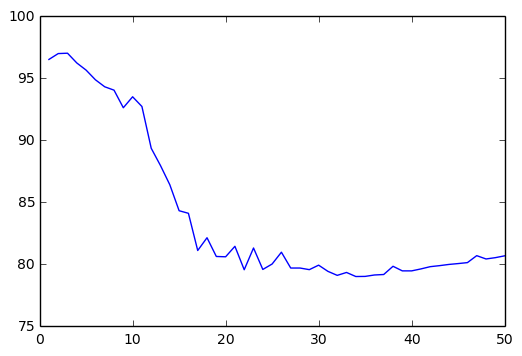

In [61]:
def plot_gauss(n, repeat, dataset, e):
    x = [i+1 for i in range(n)]
    y = []
    for i in x:
        model = MyModel(n_gauss=i, err=e)
        model.load_data(dataset)
        mean = 0
        for j in range(repeat):
            model.train()
            model.run(prefix='{} - '.format(i))
            mean += model.relative_final_space
        y.append(mean/repeat)
    
    plt.plot(x, y)
    plt.show()

plot_gauss(50, 10, 'tpc-h-5k', 0.01)
        